Dcgan
=====



[https://keras.io/examples/generative/dcgan_overriding_train_step/](https://keras.io/examples/generative/dcgan_overriding_train_step/)

To run this you will need gdown



In [1]:
!pip install gdown


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (Input, Reshape, Dropout, Dense,
                                     Flatten, BatchNormalization,
                                     Activation, ZeroPadding2D, LeakyReLU,
                                     UpSampling2D, Conv2D)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## Prepare Celeb data



In this example we will use the Celeb dataset. We will resize images to a size of `64x64`.
First download the dataset (only need to do this once, then it will throw an error but don&rsquo;t worry):



In [2]:
os.makedirs("datasets/celeba_gan", exist_ok=False)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "datasets/celeba_gan/data.zip"
gdown.download(url, output, quiet=False)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("datasets/celeba_gan")

FileExistsError: [Errno 17] File exists: 'datasets/celeba_gan'

And then convert this to a Tensorflow dataset. Because we expect to be training on our laptops, we will reduce the size of the training set. This is not ideal for GANs, but it will still produce reasonable results. Here we also scale the inputs to the `[-1, 1]` range and make sure the dataset is subdivided into batches of the desired size



In [3]:
image_size = 64 # images are square
image_channels = 3 # 3 RGB 1 Grayscale
image_shape = (image_size, image_size, image_channels)
dataset_size = 200
batch_size = 32

dataset = keras.utils.image_dataset_from_directory(
    "datasets/celeba_gan", label_mode=None, image_size=(image_size, image_size), batch_size=None)

dataset = dataset.take(dataset_size)
dataset = dataset.map(lambda x: x / 127.5 - 1.0)
dataset = dataset.batch(batch_size) # We create batch here since "take" would unbatch it..

Found 202599 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now let&rsquo;s see one random instance from the dataset:

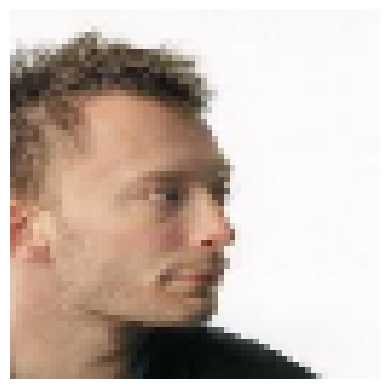

In [5]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 127.5 + 127.5).astype("int32")[0])
    break

## Create generator



At this staget we need to construct our generator. There are many implementations out there, this is one that works reasonably well for our use case and it is adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).
For GAN models it is [recommended](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/) to initialize the layers with normally distributed (Gaussian) values and standard deviation of 0.02. The following function is built to enable training on different image sizes, but we recommend sticking with the `64x64` image size:



In [24]:
kernel_size = 3
latent_dim = 100 # The size of the latent space

init = lambda: tf.keras.initializers.RandomNormal(stddev=0.02)

def build_generator():
    # From https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py
    # This block of code can be a little daunting, but essentially it automatically calculates the required starting
    # array size that will be correctly upscaled to our desired image size.
    #
    # We have 5 Upsample2D layers which each double the images width and height, so we can determine the starting
    # x size by taking (x / 2^upsample_count) So for our target image size, 256x192, we do the following:
    # x = (192 / 2^5), y = (256 / 2^5) [x and y are reversed within the model]
    # We also need a 3rd dimension which is chosen relatively arbitrarily, in this case it's 64.
    model = Sequential()
    upsample_layers = 5
    starting_filters = 128
    start_size = image_size // (2 ** upsample_layers)
    model.add(Dense(starting_filters * start_size * start_size, activation="relu", input_dim=latent_dim))
    model.add(Reshape((start_size, start_size, starting_filters)))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 6x8 -> 12x16
    model.add(Conv2D(1024, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 12x16 -> 24x32
    model.add(Conv2D(512, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 24x32 -> 48x64
    model.add(Conv2D(256, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 48x64 -> 96x128
    model.add(Conv2D(128, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())  # 96x128 -> 192x256
    model.add(Conv2D(64, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(32, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(image_channels, kernel_size=kernel_size, padding="same", kernel_initializer=init()))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

generator = build_generator()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               51712     
                                                                 
 reshape_3 (Reshape)         (None, 2, 2, 128)         0         
                                                                 
 batch_normalization_27 (Bat  (None, 2, 2, 128)        512       
 chNormalization)                                                
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 4, 4, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 4, 4, 1024)        1180672   
                                                                 
 activation_21 (Activation)  (None, 4, 4, 1024)       

Let&rsquo;s see it&rsquo;s output before training



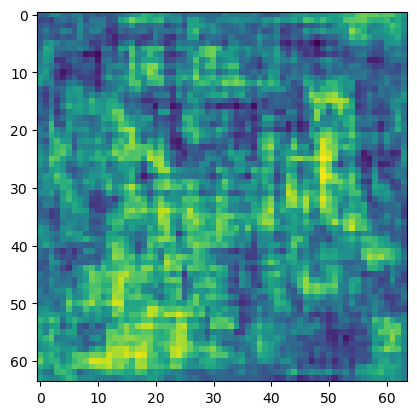

In [25]:
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=True)
plt.imshow(generated_image[0, :, :, 0])
plt.show()

## Create discriminator



We then define the discriminator model, again adapted adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).



In [26]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, strides=2, input_shape=image_shape, padding="same", kernel_initializer=init()))  # 192x256 -> 96x128
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=kernel_size, strides=2, padding="same", kernel_initializer=init()))  # 96x128 -> 48x64
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(128, kernel_size=kernel_size, strides=2, padding="same", kernel_initializer=init()))  # 48x64 -> 24x32
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Conv2D(256, kernel_size=kernel_size, strides=1, padding="same", kernel_initializer=init()))  # 24x32 -> 12x16
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, kernel_size=kernel_size, strides=1, padding="same", kernel_initializer=init()))  # 12x16 -> 6x8
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=image_shape)
    validity = model(img)

    return Model(img, validity)

discriminator = build_discriminator()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_15 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 17, 17, 64)       0         
 ng2D)                                                           
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 17, 17, 64)        0         
                                                      

Let&rsquo;s see what the discriminator thinks of our generated image:



In [9]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49969378]], shape=(1, 1), dtype=float32)


## Override `train_step`



Tensorflow and Keras offer many ways to combine the generator and discriminator into a GAN model and train it. Here we define a custom model class that overrides the `train_step` method, and define a custom loss function for the discriminator that adds smoothing to improve the convergence of the model.



In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator


    def generator_loss(self,fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)


    # smooth parameter is used to induce one sided label smoothing. It can be tuned accordingly
    def discriminator_loss(self,real_output, fake_output):
        # This version adds noise as suggested in the official Keras DCGAN example
        noise_amt = 0.01
        real_loss = cross_entropy(tf.ones_like(real_output)+tf.random.uniform(tf.shape(real_output))*noise_amt,
                                  real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output)+tf.random.uniform(tf.shape(fake_output))*noise_amt,
                                  fake_output)

        # This version adds one sided smoothing
        # label for real image is (1-smooth)
        # smooth = 0.01
        # real_loss = cross_entropy(tf.ones_like(real_output)*(1-smooth), real_output)
        # fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        # This version does the usual loss
        # real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        # fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        return real_loss + fake_loss

    def compile(self,generator_optimizer,discriminator_optimizer):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    @tf.function # This improves performance
    def train_step(self,data):
        # Standard procedure to recover batch size
        batch_size = tf.shape(data)[0]

        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size, latent_dim))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # generate image using generator
            generated_image = self.generator(seed, training=True)
            # discriminator's prediction for real image
            real_output = self.discriminator(data, training=True)

            # discriminator's estimate for fake image
            fake_output = self.discriminator(generated_image, training=True)

            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(zip(generator_grad,
                                                         self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(zip(discriminator_grad,
                                                             self.discriminator.trainable_variables))

        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }

## Create callback that periodically saves generated images



We want to visualize the results every epoch and save the resulting model and this Python class will take care of that automatically. The images and models will be saved in a specified directory. Periodically check the directory to see how the results change at each epoch.



In [28]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim, path):
        os.makedirs(path, exist_ok=True)
        self.path = path
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        #generated_images *= 255
        generated_images = generated_images * 127.5 + 127.5 #255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(self.path, "e%03d_generated_img_%d.png" % (epoch+1, i)))
        print('Saving epoch %d to %s'%(epoch+1, self.path))
        self.model.save_weights(os.path.join(self.path, "e%0d_weights"%(epoch+1)))
        self.model.generator.save(os.path.join(self.path, "e%0d_generator.hd5"%(epoch+1)), save_format='h5')

## Train the end to end model



Finally let&rsquo;s define the optimizers for the generator and discriminator (the Adam optimizer is usually recommended), compile the model and run our training procedure.
Change the value of `model_path` to change where the models and results will be saved. Here we train for `30` epochs. Depending on the size of the training set, less or more epochs may be desired. Adjust this by changing the value of the `epochs` variable below:



In [23]:
model_path = './models/dcgan_dmlap'
epochs = 30

generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

gan = DCGAN(generator, discriminator)
gan.compile(generator_optimizer,discriminator_optimizer)


gan.fit(
    dataset, epochs=epochs,
    callbacks=[GANMonitor(num_img=5,
                          latent_dim=latent_dim,
                          path=model_path)]
)

Epoch 1/30
7/7 [==============================] - 17s 2s/step - generator loss: 1.2918 - discriminator_loss: 1.2676
Epoch 2/30
7/7 [==============================] - 17s 2s/step - generator loss: 1.7361 - discriminator_loss: 0.9578
Epoch 3/30
7/7 [==============================] - 18s 2s/step - generator loss: 2.3889 - discriminator_loss: 0.4804
Epoch 4/30
7/7 [==============================] - 18s 3s/step - generator loss: 2.0010 - discriminator_loss: 0.6880
Epoch 5/30
7/7 [==============================] - 18s 3s/step - generator loss: 2.4599 - discriminator_loss: 0.5337
Epoch 6/30
7/7 [==============================] - 19s 3s/step - generator loss: 3.0133 - discriminator_loss: 1.0183
Epoch 7/30
7/7 [==============================] - 19s 3s/step - generator loss: 3.7921 - discriminator_loss: 1.0521
Epoch 8/30
7/7 [==============================] - 22s 3s/step - generator loss: 2.7710 - discriminator_loss: 0.7443
Epoch 9/30
7/7 [==============================] - 20s 3s/step - generato